## Solution to the second project

#### All the imports here

In [98]:
import numpy as np
from numpy import linspace, vstack, zeros, arange, power, abs
from mpl_toolkits.mplot3d import axes3d
from scipy.stats import norm
import random
from time import time

#### Making matplotlib more tolerable

In [99]:
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%pylab inline
plt.xkcd();

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


### Plotting functions below

In [100]:
#plotting functions here

### Task 2.1 (yobibyte)

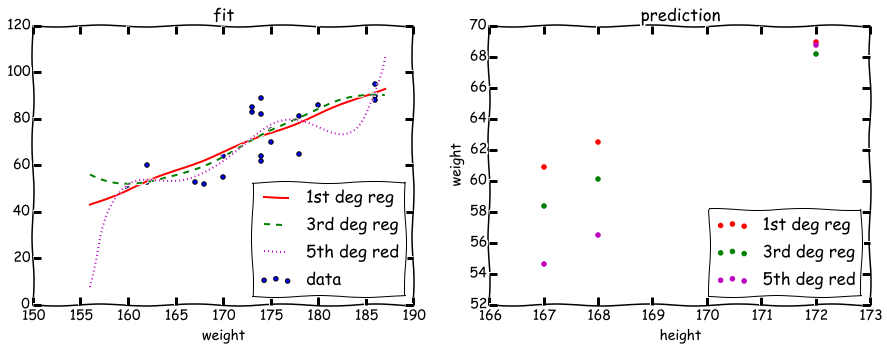

In [101]:
dt = np.dtype([('w', np.float), ('h', np.float), ('g', 'S1')])
data = np.loadtxt('resources/whData.dat', dtype=dt, comments='#', delimiter=None)

ws = data['w']
hs = data['h']
gs = np.array([el.decode('utf-8') for el in data['g']])

hs_t = hs[np.where(ws < 0)]
gs_t = gs[np.where(ws < 0)]
ws_t = ws[np.where(ws < 0)]

hs = np.delete(hs, np.where(ws < 0), None)
gs = np.delete(gs, np.where(ws < 0), None)
ws = np.delete(ws, np.where(ws < 0), None)

p = np.poly1d(polyfit(hs,ws,1))
p3 = np.poly1d(polyfit(hs,ws,3))
p5 = np.poly1d(polyfit(hs,ws,5))
xp = np.linspace(156, 187, 100)

colors = ['r'if el=='f' else 'b' for el in gs]

fig,axes = subplots(ncols=2, figsize=(15,5))
ax = axes[0]
ax2 = axes[1]

ax.set_title('fit')
ax.set_xlabel('height')
ax.set_xlabel('weight')
ax.scatter(hs, ws, label='data')
ax.plot(xp, p(xp), '-', label='1st deg reg', color='r')
ax.plot(xp, p3(xp), '--', label='3rd deg reg',color='g')
ax.plot(xp, p5(xp), ':', label='5th deg red',color='m')
legend = ax.legend(loc='lower right')

ax2.set_ylabel('weight')
ax2.set_xlabel('height')
ax2.set_title('prediction')
ax2.scatter(hs_t, p(hs_t), label='1st deg reg', color='r')
ax2.scatter(hs_t, p3(hs_t), label='3rd deg reg',color='g')
ax2.scatter(hs_t, p5(hs_t), label='5th deg red',color='m')
legend = ax2.legend(loc='lower right')

### Task 2.2

In [102]:
#Code here

### Task 2.3

In [103]:
#Code here

### Task 2.4 (yobibyte)

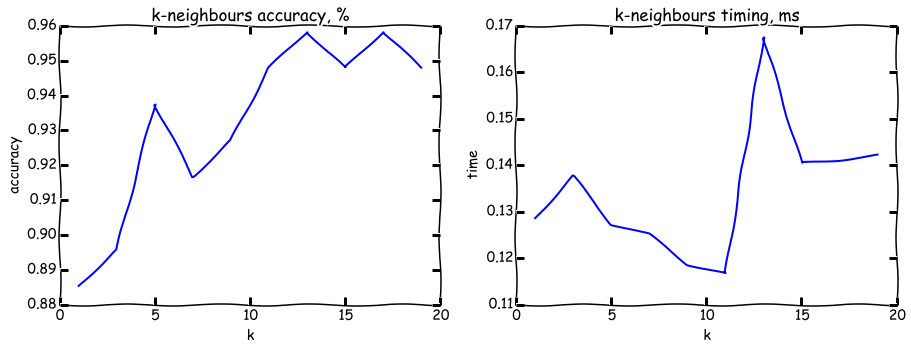

In [104]:
n = [1,3,5,7,9,11,13,15,17,19]

dt = np.dtype([('x1', np.float), ('x2', np.float), ('y',  np.float)])

data = np.loadtxt('resources/data2-train.dat', dtype=dt, comments='#', delimiter=None)
Xtr,ytr = np.array([[el[0],el[1]] for el in data]),data['y']

data = np.loadtxt('resources/data2-test.dat', dtype=dt, comments='#', delimiter=None)
Xt,yt = np.array([[el[0],el[1]] for el in data]),data['y']

#k-neighbours train is just storing the train data
#that is already done

#test
preds = []
timing = []
for k in n:
    st_t = time()
    curr_pred = []
    for p in Xt:
        dist = [np.abs(np.linalg.norm(tr-p)) for tr in Xtr]
        neighbours = np.argsort(dist)[:k]
        n_vals = ytr[neighbours]
        #hey! will be strange for even k's
        pred = 1.0 if sum(n_vals) > 0 else -1.0
        curr_pred.append(pred)
    timing.append(time()-st_t)
    preds.append(curr_pred)
    
acc = []
for p in preds:
    corr = [i==j for i,j in zip(yt,p)]
    corr = sum(corr)/len(corr)
    acc.append(corr)
    
fig,axes = subplots(ncols=2, figsize=(15,5))
ax = axes[0]
ax2 = axes[1]

ax.set_title('k-neighbours accuracy, %')
ax.set_xlabel('k')
ax.set_ylabel('accuracy')
ax.plot(n, acc);    

ax2.set_title('k-neighbours timing, ms')
ax2.set_xlabel('k')
ax2.set_ylabel('time')
ax2.plot(n, timing);

### Task 2.5

In [105]:
#Code here